<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e5?scriptVersionId=175518209" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://whyy.org/wp-content/uploads/2021/09/AP_hurricane_ida_flooding_storm_090221_04-768x512.jpg)

# <span style="color: #44944A">I really sympathize with the people who had to go through the flood. I hope the governments of such countries will do everything possible to help people restore their property and life stability!

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


## *Your Goal*: The goal of this competition is to predict the probability of a region flooding based on various factors.

<font face="Bahnschrift Condensed" style="font-size: 14pt; color: brown">
Flood detection refers to the process of identifying, monitoring, and alerting authorities or individuals about the presence or likelihood of flooding in a particular area. It involves the use of various technologies and methods to detect, predict, and mitigate the impacts of floods.
</font>

![](https://www.kaggle.com/competitions/73278/images/header)

# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 50px;">Table of Contents</span>

- [Import libraries](#1)
- [Open data files](#2)
- [Show first 5 lines of train data](#3)
- [Compare original train and competition train](#3.1)
- [Concatenate original train with competition train](#3.2)
- [Figure out how much duplicates in data](#3.3)
- [Shapes of train and test data](#4)
- [Display descriptive statistics of train data](#5)
- [Check the number of gaps for each feature](#6)
- [One-hot encoding](#7.3)
- [Display histograms of distribution](#8)
- [Let's count target of train data](#9)
- [Transform the data with log1p](#10)
- [Feature importance](#10.2)
- [Build a heat map of correlations](#11)
- [Define base models with tuned hyperparameters](#12)
- [Defining the meta-model with tuned hyperparameters](#13)
- [Creating and fitting the stacking model](#14)
- [Predict validation set and calculate metrics score](#15)
- [Predict the test data](#16)
- [Build DataFrame and make submission](#17)
- [Save the model into pickle file](#18)

<a id='1'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 Import libraries</span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

![](https://s.france24.com/media/display/f441dde2-f637-11ed-aeef-005056bf30b7/w:980/p:16x9/000_33FG2YF.jpg)

<a id='2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')

<a id='3'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛈️ Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


In [5]:
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415


## <span style="color: #A8E4A0">Target feature is **FloodProbability**

<a id='3.1'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Compare original train and competition train</span>

In [6]:
print(original_train.shape)
original_train.columns.tolist()

(50000, 21)


['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability']

## <span style="color: #A8E4A0">In original data there is no **id** column

In [7]:
print(train.shape)
train.columns.tolist()

(1117957, 22)


['id',
 'MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors',
 'FloodProbability']

<a id='3.2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚣 Concatenate original train with competition train

In [8]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

In [9]:
train = pd.concat(objs=[train, original_train])
train.shape

(1167957, 21)

<a id='3.3'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🛟 Figure out how much duplicates in data

In [10]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

0
0


<a id='4'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0">🚨 Shapes of train and test data</span>

In [11]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100:.2f}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100:.2f}% of all observations')

Train data: (1167957, 21)
Test data: (745305, 20)

Train data consists of 61.05% of all observations
Test data consists of 38.95% of all observations


![](https://akm-img-a-in.tosshub.com/lingo/itne/images/story/202208/new_project_18-sixteen_nine.jpg?size=948:533)

<a id='5'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚧 Display descriptive statistics of train data</span>

In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonsoonIntensity,1167957.0,4.924448,2.064482,0.000,3.00,5.000,6.00,16.000
TopographyDrainage,1167957.0,4.929129,2.100671,0.000,3.00,5.000,6.00,18.000
RiverManagement,1167957.0,4.957917,2.079283,0.000,4.00,5.000,6.00,16.000
Deforestation,1167957.0,4.945076,2.059346,0.000,4.00,5.000,6.00,17.000
Urbanization,1167957.0,4.944509,2.090501,0.000,3.00,5.000,6.00,17.000
ClimateChange,1167957.0,4.936415,2.065289,0.000,3.00,5.000,6.00,17.000
DamsQuality,1167957.0,4.958424,2.090286,0.000,4.00,5.000,6.00,16.000
Siltation,1167957.0,4.930394,2.073436,0.000,3.00,5.000,6.00,16.000
AgriculturalPractices,1167957.0,4.945338,2.075964,0.000,3.00,5.000,6.00,16.000
Encroachments,1167957.0,4.951676,2.090378,0.000,4.00,5.000,6.00,18.000


<a id='6'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🏥 Check the number of gaps for each feature</span>

In [13]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64



TEST data

MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0

## <span style="color: #A8E4A0">There is no any gaps in the data

![](https://img.theweek.in/content/dam/week/week/news/world/images/2024/4/6/Russia-floods-reuters.jpg)

<a id='7'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌧️ Data types of training set</span>

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1167957 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   MonsoonIntensity                 1167957 non-null  int64  
 1   TopographyDrainage               1167957 non-null  int64  
 2   RiverManagement                  1167957 non-null  int64  
 3   Deforestation                    1167957 non-null  int64  
 4   Urbanization                     1167957 non-null  int64  
 5   ClimateChange                    1167957 non-null  int64  
 6   DamsQuality                      1167957 non-null  int64  
 7   Siltation                        1167957 non-null  int64  
 8   AgriculturalPractices            1167957 non-null  int64  
 9   Encroachments                    1167957 non-null  int64  
 10  IneffectiveDisasterPreparedness  1167957 non-null  int64  
 11  DrainageSystems                  1167957 non-null  int64 

<a id="7.3"></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 One-hot encoding

In [15]:
# X = pd.get_dummies(train, drop_first=True, dtype=int)
# test = pd.get_dummies(test, drop_first=True, dtype=int)

## <span style="color: #A8E4A0">Boostings and Random Forest can tackle with data without normalization

<a id='8'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Display histograms of distribution</span>

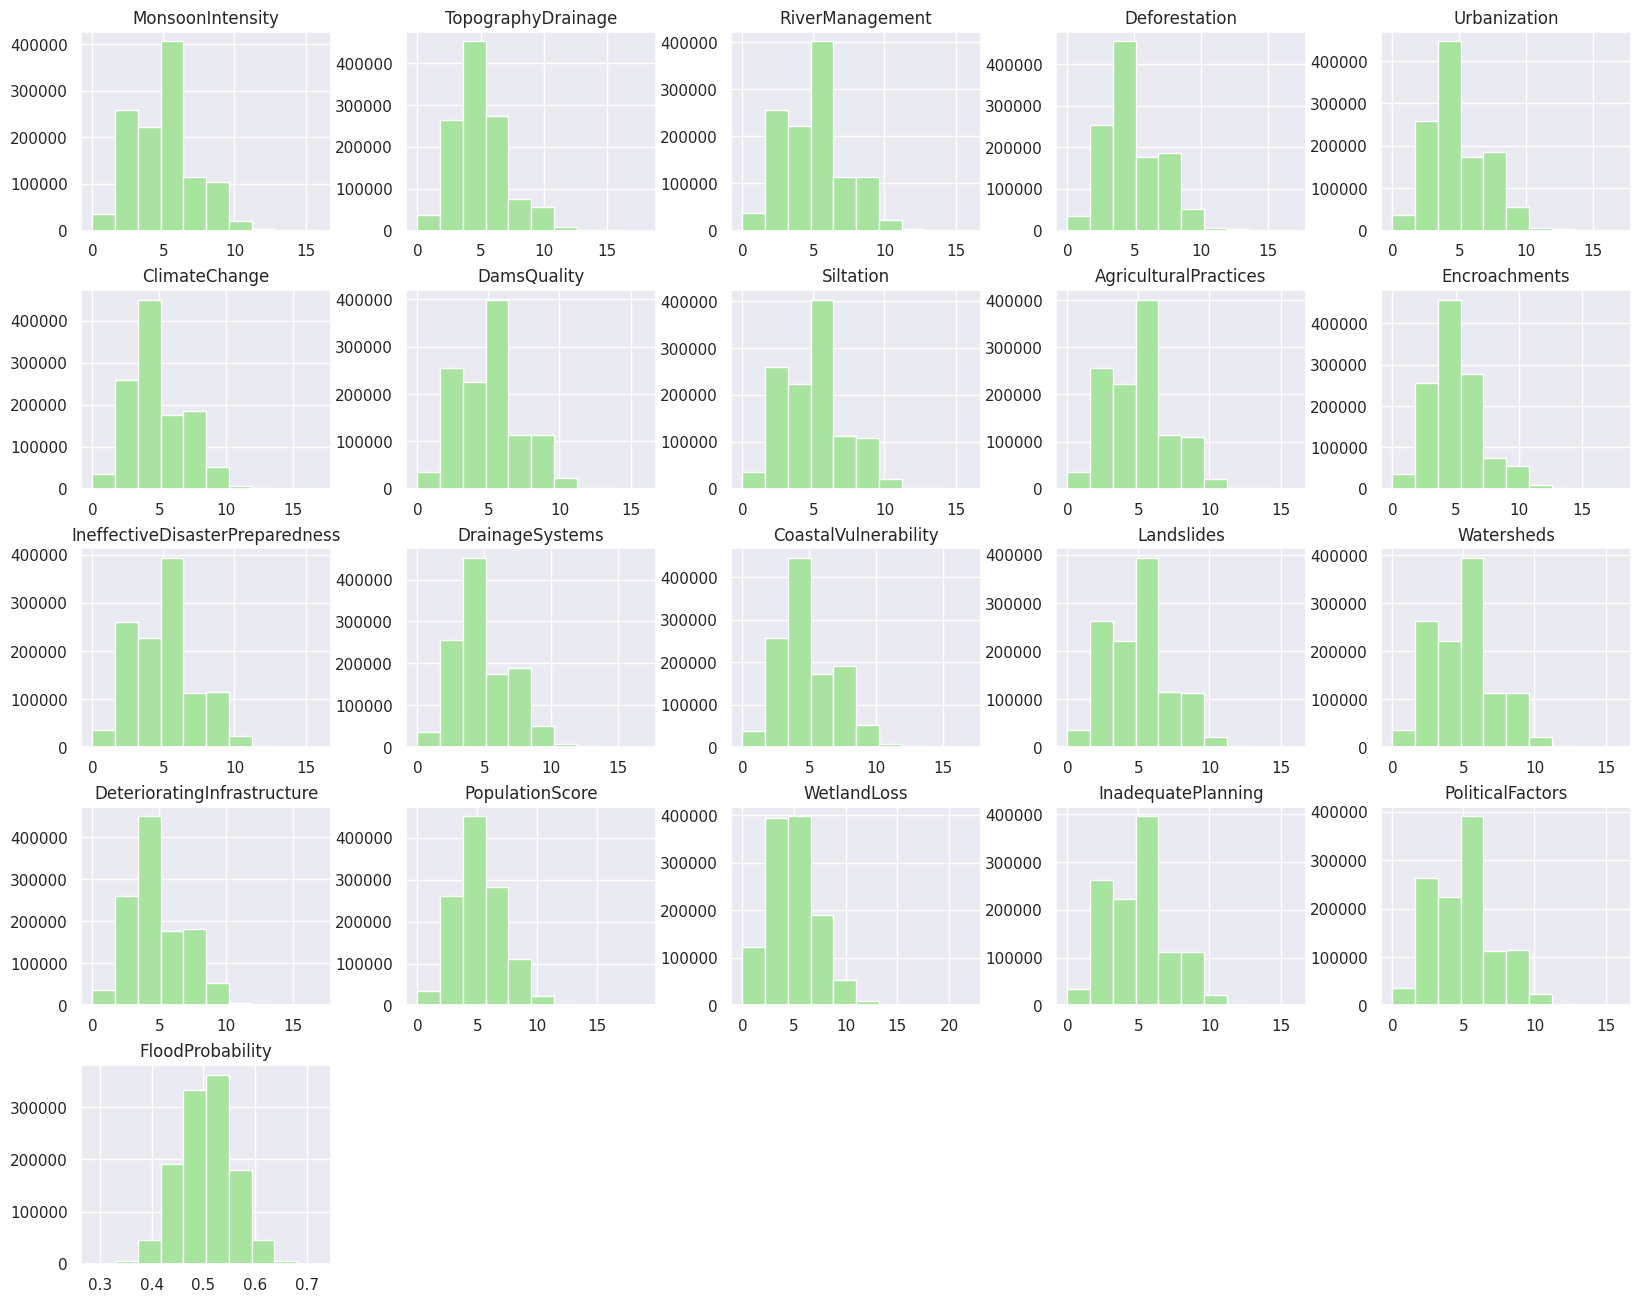

In [16]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='#A8E4A0');

<a id='10.2'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛈️ Feature importance</span>

In [17]:
# Split the train data into X and y
X = train.drop(['FloodProbability'], axis=1)
y = train.FloodProbability

In [18]:
%%time
# I figured out best hyperparameters previously
best_cat = CatBoostRegressor(
    random_state=27,
)
    
best_cat.fit(X, y)

Learning rate set to 0.124978
0:	learn: 0.0500852	total: 273ms	remaining: 4m 32s
1:	learn: 0.0491846	total: 448ms	remaining: 3m 43s
2:	learn: 0.0482825	total: 621ms	remaining: 3m 26s
3:	learn: 0.0474705	total: 781ms	remaining: 3m 14s
4:	learn: 0.0466906	total: 941ms	remaining: 3m 7s
5:	learn: 0.0459228	total: 1.1s	remaining: 3m 1s
6:	learn: 0.0451907	total: 1.26s	remaining: 2m 58s
7:	learn: 0.0445132	total: 1.41s	remaining: 2m 55s
8:	learn: 0.0438386	total: 1.59s	remaining: 2m 55s
9:	learn: 0.0431741	total: 1.76s	remaining: 2m 54s
10:	learn: 0.0425871	total: 1.91s	remaining: 2m 51s
11:	learn: 0.0419977	total: 2.06s	remaining: 2m 50s
12:	learn: 0.0414196	total: 2.21s	remaining: 2m 48s
13:	learn: 0.0408611	total: 2.36s	remaining: 2m 46s
14:	learn: 0.0403253	total: 2.51s	remaining: 2m 44s
15:	learn: 0.0397815	total: 2.7s	remaining: 2m 46s
16:	learn: 0.0392538	total: 2.85s	remaining: 2m 44s
17:	learn: 0.0387648	total: 2.99s	remaining: 2m 42s
18:	learn: 0.0382793	total: 3.13s	remaining: 2m 

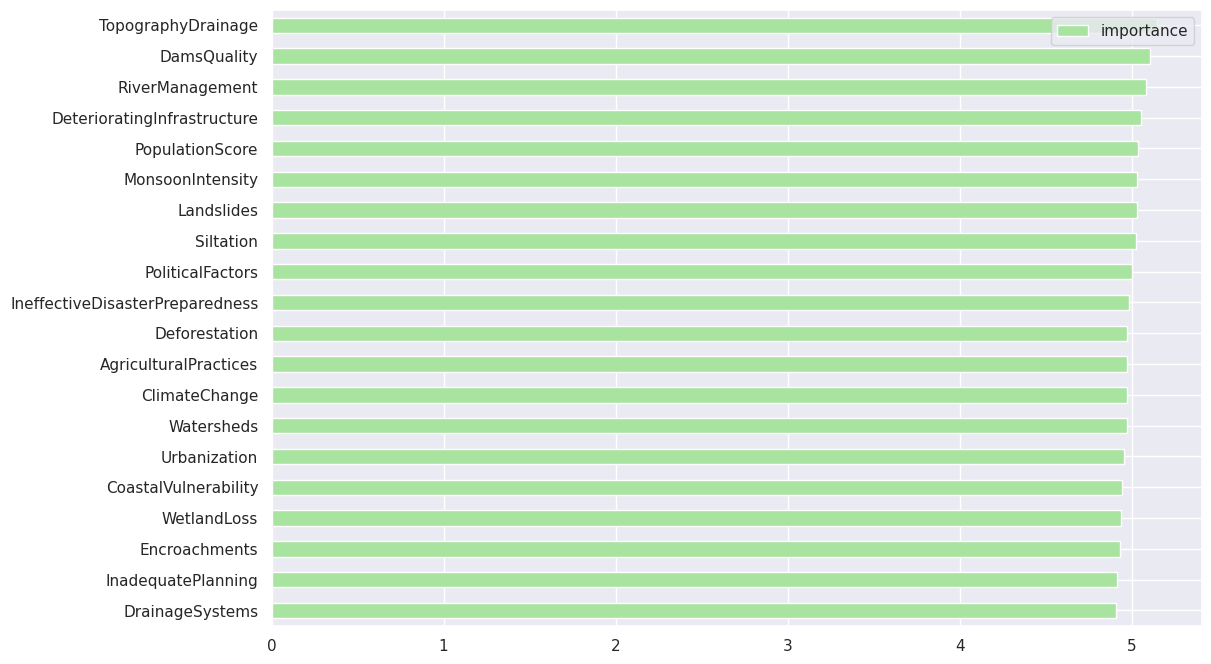

In [19]:
importance = best_cat.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='#A8E4A0');

## <span style="color: #A8E4A0">All features have almost same importance

<a id='11'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Build a heat map of correlations</span>

In [20]:
X.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

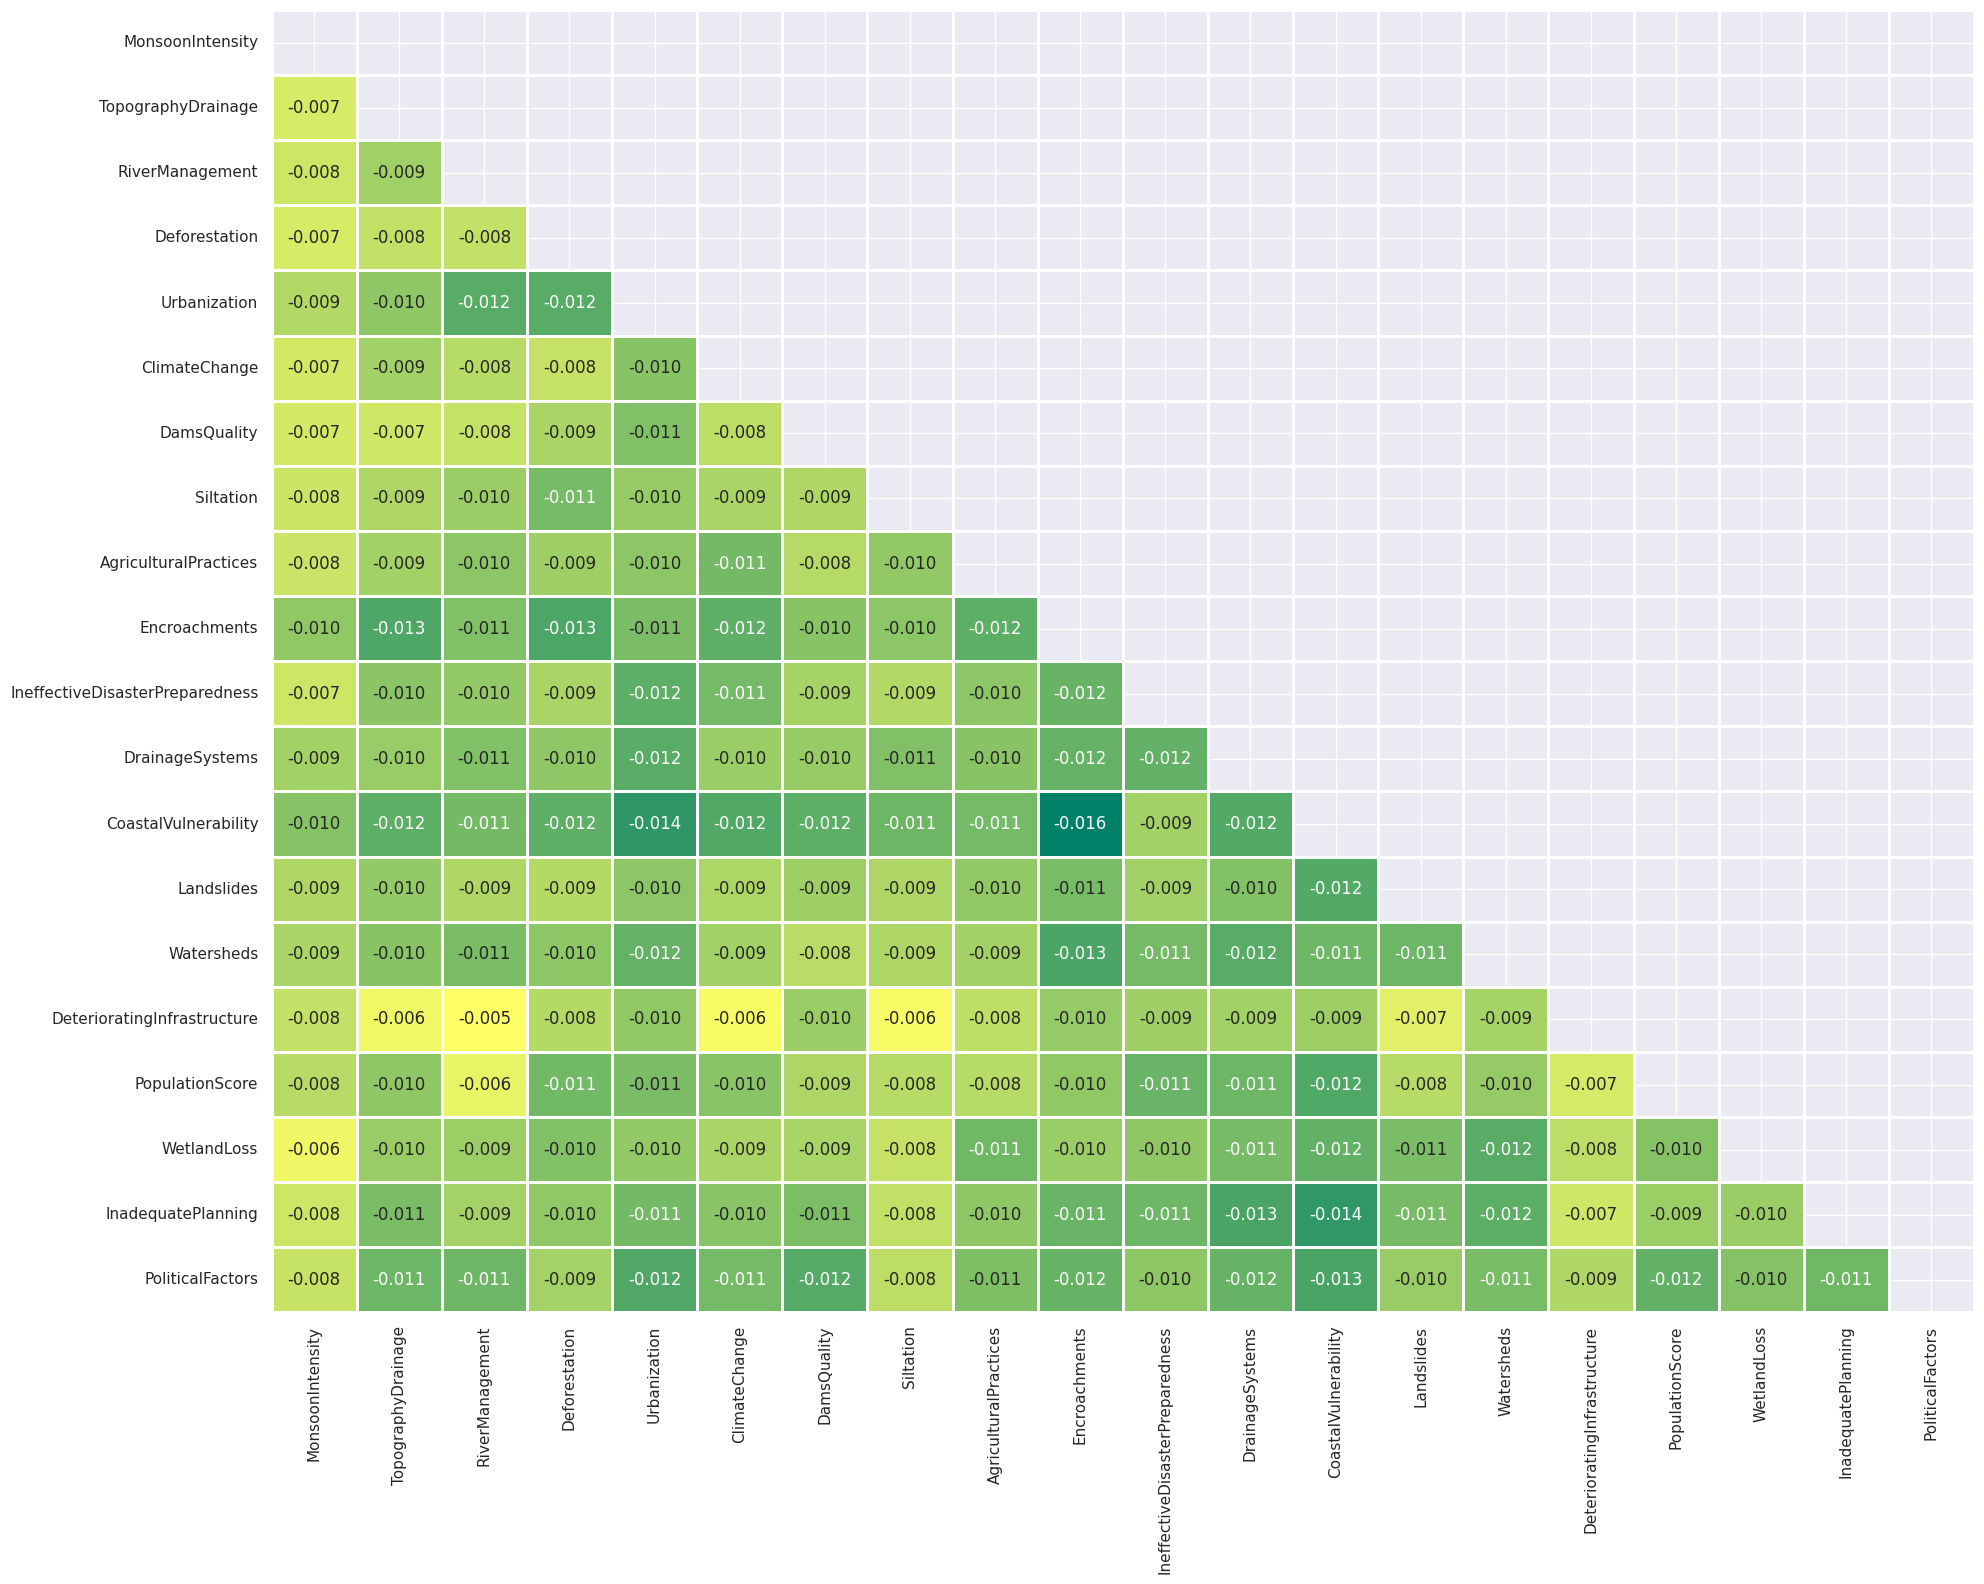

In [21]:
# Training dataset
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.3f', mask=mask_train, cmap='summer', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

## <span style="color: #A8E4A0">There is no high correlated features

<a id='12'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🚣 Define base models</span>

## <p style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">CatBoost with Optuna</p>

In [22]:
# %%time
# def objective(trial):
#     model = CatBoostRegressor(
#         iterations=trial.suggest_int("iterations", 100, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
#         depth=trial.suggest_int("depth", 2, 16),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         verbose=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(r2_score(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=50)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

""" Attempt 1
Number of finished trials:  20
Best trial:
  Value:  0.9221420111931355
  Params: 
    iterations: 995
    learning_rate: 0.07654523783160556
    colsample_bylevel: 0.4717753249785409
    min_data_in_leaf: 55
    depth: 5
    l2_leaf_reg: 0.3477364859003808

CPU times: user 1h 30min 53s, sys: 1min 25s, total: 1h 32min 19s
Wall time: 25min 58s


Attempt 2
Number of finished trials:  20
Best trial:
  Value:  0.9221770378752769
  Params: 
    iterations: 735
    learning_rate: 0.07024611544300416
    colsample_bylevel: 0.32374524982071545
    min_data_in_leaf: 69
    depth: 9
    l2_leaf_reg: 5.938240087759686

CPU times: user 2h 7min 19s, sys: 1min 43s, total: 2h 9min 2s
Wall time: 38min 17s
"""

' Attempt 1\nNumber of finished trials:  20\nBest trial:\n  Value:  0.9221420111931355\n  Params: \n    iterations: 995\n    learning_rate: 0.07654523783160556\n    colsample_bylevel: 0.4717753249785409\n    min_data_in_leaf: 55\n    depth: 5\n    l2_leaf_reg: 0.3477364859003808\n\nCPU times: user 1h 30min 53s, sys: 1min 25s, total: 1h 32min 19s\nWall time: 25min 58s\n\n\nAttempt 2\nNumber of finished trials:  20\nBest trial:\n  Value:  0.9221770378752769\n  Params: \n    iterations: 735\n    learning_rate: 0.07024611544300416\n    colsample_bylevel: 0.32374524982071545\n    min_data_in_leaf: 69\n    depth: 9\n    l2_leaf_reg: 5.938240087759686\n\nCPU times: user 2h 7min 19s, sys: 1min 43s, total: 2h 9min 2s\nWall time: 38min 17s\n'

## <p style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">XGBoost with Optuna</p>

In [23]:
# %%time
# def objective(trial):
#     model = XGBRegressor(
#         max_depth=trial.suggest_int('max_depth', 1, 100),
#         learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#         n_estimators=trial.suggest_int('n_estimators', 50, 1000),
#         min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
#         gamma=trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         use_label_encoder=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     try:
#         return np.sqrt(r2_score(y_test, y_pred))
#     except Exception as e:
#         print(e)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=20)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  20
Best trial:
  Value:  0.9220549398917139
  Params: 
    max_depth: 13
    learning_rate: 0.22472048294428892
    n_estimators: 767
    min_child_weight: 10
    gamma: 8.58031910185836e-07
    subsample: 0.8936985751131682
    colsample_bytree: 0.04050040446078567
    reg_alpha: 0.16025160863896398
    reg_lambda: 6.875124639971543e-08

CPU times: user 1h 4min 43s, sys: 10.8 s, total: 1h 4min 54s
Wall time: 16min 40s
"""

'\nNumber of finished trials:  20\nBest trial:\n  Value:  0.9220549398917139\n  Params: \n    max_depth: 13\n    learning_rate: 0.22472048294428892\n    n_estimators: 767\n    min_child_weight: 10\n    gamma: 8.58031910185836e-07\n    subsample: 0.8936985751131682\n    colsample_bytree: 0.04050040446078567\n    reg_alpha: 0.16025160863896398\n    reg_lambda: 6.875124639971543e-08\n\nCPU times: user 1h 4min 43s, sys: 10.8 s, total: 1h 4min 54s\nWall time: 16min 40s\n'

## <p style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px; background-image: url(https://www.kaggle.com/competitions/73278/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">LightGBM with Optuna</p>

In [24]:
%%time
def objective(trial):
    model = LGBMRegressor(
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        max_depth=trial.suggest_int("max_depth", 1, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        verbosity=-1,
        boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        num_leaves=trial.suggest_int('num_leaves', 2, 256),
        min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
        random_state=27
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.sqrt(r2_score(y_test, y_pred))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=27)
study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=5)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print()

"""
Number of finished trials:  5
Best trial:
  Value:  0.9166237437815526
  Params: 
    n_estimators: 483
    max_depth: 82
    learning_rate: 0.02956613668999794
    boosting_type: gbdt
    num_leaves: 251
    min_child_samples: 90

CPU times: user 46min 34s, sys: 7.39 s, total: 46min 42s
Wall time: 45min 1s
"""

<timed exec>:14: RuntimeWarning: invalid value encountered in sqrt
[W 2024-05-03 21:42:34,418] Trial 3 failed with parameters: {'n_estimators': 374, 'max_depth': 79, 'learning_rate': 0.002117446099339252, 'boosting_type': 'dart', 'num_leaves': 48, 'min_child_samples': 62} because of the following error: The value nan is not acceptable.
[W 2024-05-03 21:42:34,419] Trial 3 failed with value nan.
<timed exec>:14: RuntimeWarning: invalid value encountered in sqrt
[W 2024-05-03 22:08:51,152] Trial 4 failed with parameters: {'n_estimators': 474, 'max_depth': 52, 'learning_rate': 0.0027625639862136286, 'boosting_type': 'dart', 'num_leaves': 238, 'min_child_samples': 75} because of the following error: The value nan is not acceptable.
[W 2024-05-03 22:08:51,153] Trial 4 failed with value nan.


Number of finished trials:  5
Best trial:
  Value:  0.9166237437815526
  Params: 
    n_estimators: 483
    max_depth: 82
    learning_rate: 0.02956613668999794
    boosting_type: gbdt
    num_leaves: 251
    min_child_samples: 90

CPU times: user 45min 47s, sys: 9.27 s, total: 45min 57s
Wall time: 44min 13s


'\nNumber of finished trials:  5\nBest trial:\n  Value:  0.9166237437815526\n  Params: \n    n_estimators: 483\n    max_depth: 82\n    learning_rate: 0.02956613668999794\n    boosting_type: gbdt\n    num_leaves: 251\n    min_child_samples: 90\n\nCPU times: user 46min 34s, sys: 7.39 s, total: 46min 42s\nWall time: 45min 1s\n'

In [25]:
# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

![](https://img.eurointegration.com.ua/images/doc/f/b/fbb045d-0-scotland.png)

In [26]:
cat = CatBoostRegressor(
    iterations=735,
    learning_rate=0.07024611544300416,
    colsample_bylevel=0.32374524982071545,
    min_data_in_leaf=69,
    depth=9,
    l2_leaf_reg=5.938240087759686,
)

cat.fit(X_train, y_train)

0:	learn: 0.0502063	total: 162ms	remaining: 1m 58s
1:	learn: 0.0494509	total: 302ms	remaining: 1m 50s
2:	learn: 0.0487082	total: 449ms	remaining: 1m 49s
3:	learn: 0.0480103	total: 584ms	remaining: 1m 46s
4:	learn: 0.0473287	total: 735ms	remaining: 1m 47s
5:	learn: 0.0466577	total: 888ms	remaining: 1m 47s
6:	learn: 0.0460179	total: 1.06s	remaining: 1m 49s
7:	learn: 0.0454120	total: 1.19s	remaining: 1m 47s
8:	learn: 0.0448304	total: 1.32s	remaining: 1m 46s
9:	learn: 0.0442606	total: 1.46s	remaining: 1m 45s
10:	learn: 0.0437094	total: 1.6s	remaining: 1m 45s
11:	learn: 0.0431885	total: 1.73s	remaining: 1m 44s
12:	learn: 0.0426769	total: 1.87s	remaining: 1m 43s
13:	learn: 0.0421690	total: 2.02s	remaining: 1m 43s
14:	learn: 0.0416770	total: 2.17s	remaining: 1m 44s
15:	learn: 0.0412148	total: 2.3s	remaining: 1m 43s
16:	learn: 0.0407509	total: 2.44s	remaining: 1m 42s
17:	learn: 0.0402974	total: 2.58s	remaining: 1m 42s
18:	learn: 0.0398558	total: 2.72s	remaining: 1m 42s
19:	learn: 0.0394313	tot

In [27]:
y_pred_val = cat.predict(X_val)

r2_val = np.sqrt(r2_score(y_val, y_pred_val))
print('Version 2, R^2 score: 0.92242615 (Default CatBoost)')
print(f"R^2 score: {r2_val:.8f}")

Version 2, R^2 score: 0.92242615 (Default CatBoost)
R^2 score: 0.92220429


In [28]:
%%time
xgb = XGBRegressor(
    max_depth=13,
    learning_rate=0.22472048294428892,
    n_estimators=767,
    min_child_weight=10,
    gamma=8.58031910185836e-07,
    subsample=0.8936985751131682,
    colsample_bytree=0.04050040446078567,
    reg_alpha=0.16025160863896398,
    reg_lambda=6.875124639971543e-08,
    random_state=27,
)

xgb.fit(X_train, y_train)
y_pred_val = xgb.predict(X_val)
r2_val = np.sqrt(r2_score(y_val, y_pred_val))
print(f"XGB Regressor R^2 score: {r2_val:.8f}")

XGB Regressor R^2 score: 0.92205494
CPU times: user 2min 35s, sys: 143 ms, total: 2min 35s
Wall time: 2min 35s


In [29]:
%%time
lgbm = LGBMRegressor(
    n_estimators=483,
    max_depth=82,
    learning_rate=0.02956613668999794,
    boosting_type='gbdt',
    num_leaves=251,
    min_child_samples=90,
    random_state=27,
)

lgbm.fit(X_train, y_train)
y_pred_val = lgbm.predict(X_val)
r2_val = np.sqrt(r2_score(y_val, y_pred_val))
print(f"LGBM Regressor R^2 score: {r2_val:.8f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.350525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 934365, number of used features: 20
[LightGBM] [Info] Start training from score 0.504282
LGBM Regressor R^2 score: 0.91662374
CPU times: user 3min 58s, sys: 173 ms, total: 3min 58s
Wall time: 3min 58s


In [30]:
base_models = [
    ('XGBoost', XGBRegressor(
        max_depth=13,
        learning_rate=0.22472048294428892,
        n_estimators=767,
        min_child_weight=10,
        gamma=8.58031910185836e-07,
        subsample=0.8936985751131682,
        colsample_bytree=0.04050040446078567,
        reg_alpha=0.16025160863896398,
        reg_lambda=6.875124639971543e-08,
    )),
#     ('LightGBM', LGBMRegressor(
#         n_estimators=483,
#         max_depth=82,
#         learning_rate=0.02956613668999794,
#         boosting_type='gbdt',
#         num_leaves=251,
#         min_child_samples=90,
#         random_state=27,
#     )),
    ('CatBoost', CatBoostRegressor(
        iterations=735,
        learning_rate=0.07024611544300416,
        colsample_bylevel=0.32374524982071545,
        min_data_in_leaf=69,
        depth=9,
        l2_leaf_reg=5.938240087759686,
    )),
]

<a id='13'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛵ Defining the meta-model</span>

In [31]:
meta_model = LGBMRegressor(
    n_estimators=483,
    max_depth=82,
    learning_rate=0.02956613668999794,
    boosting_type='gbdt',
    num_leaves=251,
    min_child_samples=90,
    random_state=27,
)

<a id='14'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Creating and fitting the stacking model

In [32]:
%%time
# Validation model
stacking_valid_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_valid_model.fit(X_train, y_train)

# Testing model
stacking_test_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_test_model.fit(X, y)

0:	learn: 0.0502063	total: 171ms	remaining: 2m 5s
1:	learn: 0.0494509	total: 319ms	remaining: 1m 56s
2:	learn: 0.0487082	total: 496ms	remaining: 2m
3:	learn: 0.0480103	total: 652ms	remaining: 1m 59s
4:	learn: 0.0473287	total: 811ms	remaining: 1m 58s
5:	learn: 0.0466577	total: 962ms	remaining: 1m 56s
6:	learn: 0.0460179	total: 1.11s	remaining: 1m 55s
7:	learn: 0.0454120	total: 1.25s	remaining: 1m 53s
8:	learn: 0.0448304	total: 1.4s	remaining: 1m 52s
9:	learn: 0.0442606	total: 1.54s	remaining: 1m 51s
10:	learn: 0.0437094	total: 1.69s	remaining: 1m 51s
11:	learn: 0.0431885	total: 1.83s	remaining: 1m 50s
12:	learn: 0.0426769	total: 1.98s	remaining: 1m 49s
13:	learn: 0.0421690	total: 2.14s	remaining: 1m 50s
14:	learn: 0.0416770	total: 2.3s	remaining: 1m 50s
15:	learn: 0.0412148	total: 2.44s	remaining: 1m 49s
16:	learn: 0.0407509	total: 2.59s	remaining: 1m 49s
17:	learn: 0.0402974	total: 2.74s	remaining: 1m 49s
18:	learn: 0.0398558	total: 2.89s	remaining: 1m 49s
19:	learn: 0.0394313	total: 3

StackingRegressor(estimators=[('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.04050040446078567,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=8.58031910185836e-07,
                                            grow_policy=None,
                                            importance_type=None,
                                            inter...
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=767, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('CatBoost',
                               <catboost.core.CatBoostRegressor object at 0x78aab9d71cf0>)],
                  final_estimator=LGBMRegressor(learning_rate=0.02956613668999794,
                                                max_depth=82,
                                                min_child_samples=90,
                                                n_estimators=483,
                                                num_leaves=251,
                                                random_state=27))

<a id='15'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⛈️ Predict the validation set and calculate R^2 score</span>

In [33]:
y_pred_val = stacking_valid_model.predict(X_val)

r2_val = r2_score(y_val, y_pred_val)
print(f"R^2 score: {r2_val:.8f}")

R^2 score: 0.86753960


## <span style="color: #A8E4A0">Meta models:
- CatBoost: R^2 score = 0.86739402
- XGBoost: R^2 score: 0.86737344
- LGBM: R^2 score: 0.86744553

<a id='16'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">🌊 Predict on the test data</span>

In [34]:
y_pred_test = stacking_test_model.predict(test)
y_pred_test[:10]

array([0.57694345, 0.4563312 , 0.45095316, 0.47060025, 0.4703922 ,
       0.50706029, 0.53397571, 0.52782755, 0.47341592, 0.57648374])

![](https://rg.ru/uploads/images/2023/07/10/111sirius_d09.jpg)

<a id='17'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">⚠️ Build DataFrame and make first submission</span>

In [35]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'FloodProbability': y_pred_test
})

submission.to_csv('Kapturov_S4E5_submission.csv', index=False)
submission.head(10)

,id,FloodProbability
0,1117957,0.576943
1,1117958,0.456331
2,1117959,0.450953
3,1117960,0.470600
4,1117961,0.470392
5,1117962,0.507060
6,1117963,0.533976
7,1117964,0.527828
8,1117965,0.473416
9,1117966,0.576484


<a id='18'></a>
# <span style="border-radius: 30px; border: aqua solid; padding: 0px 10px 0px 10px;color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #A8E4A0;">😨 Save the model into pickle file</span>

In [36]:
pickle.dump(cat, open("Kapturov_stacking_model.pkl", "wb"))

![](https://ichef.bbci.co.uk/ace/ws/640/cpsprodpb/14766/production/_109641838_057966017-1.jpg)